## Importing modules and packages

In [14]:
# Importing packages
import pandas as pd
import numpy  as np
import folium
import os.path
import shapely
import matplotlib.pyplot as plt
from IPython.display import IFrame

# Importing modules
import gr_mapmatch # Contains functions that perform the map matching of roads
import gr_placematch # Contains functions that perform the map matching of places
import gr_utils # Contains useful geometry functions
import gr_plot # Contains plotting routines
import gr_process

## Input parameters

In [2]:
trailname = 'gr122' # Name of the hiking trail to be considered (will search for trail.csv or trail.gpx as sources)

## Loading data

In [3]:
trail = gr_utils.get_gpx(trailname)
filename_processed = 'data_output/' + trailname + '_processed.csv'
if not os.path.isfile(filename_processed): # The PROCESSED file does not exist
    ValueError('Error file not found, did you process it?')
data = pd.read_csv(filename_processed,dtype={'highway':str, 'surface': str, 'tracktype':str, 'city8':str, 'city9':str, 'city':str},index_col=0)

Loading trail points from <data_input/gr122.gpx>...
Finished loading.


## Plotting

In [4]:
# Calculating focus point
focus = gr_plot.get_focus(trail)

In [5]:
# Plotting development type
filepath = gr_plot.show_development(data,focus)
IFrame(filepath, width=1000, height=500)

In [6]:
# Plotting traffic type
filepath = gr_plot.show_traffic(data,focus)
IFrame(filepath, width=1000, height=500)

In [8]:
# Plotting paved type with highway/surface/tracktype labels
filepath = gr_plot.show_paved_detail(data,focus)
IFrame(filepath, width=1000, height=500)

In [9]:
# Plotting GR type with highway/surface/tracktype labels
filepath = gr_plot.show_type_detail(data,focus)
IFrame(filepath, width=1000, height=500)

In [109]:
# # Paved and unpaved sections
# tot_unpaved = data[~data['paved']]['d_cart'].sum()
# tot_paved = data[data['paved']]['d_cart'].sum()
# tot = tot_unpaved + tot_paved
# print(f'Percentage paved: {round(tot_paved/tot,3)}')
# print(f'Percentage unpaved: {round(tot_unpaved/tot,3)}')

In [110]:
## Calculations for segmented plot
# Figuring out delta_d
data['d_cum'] = data['d_cart'].cumsum()
data['d0'] = data['d_cum'].shift(1)
data.loc[0,'d0'] = 0
data['d1'] = data['d_cum']
# Settings
d_per_plot = 25 # distance covered by each suplot [km]
d_max = data.tail(1)['d0'].values.tolist()[0]
n_plots = int(np.ceil(d_max/(d_per_plot*1000)))
n_points = data.shape[0]

In [ ]:
# Figuring out mean index of each cityname
vc = data['city'].value_counts()
nmin = 100
large_vc = vc>nmin
cities = vc[large_vc].index.tolist() # The cities that occur more than nmin times
cities_imed = []
cities_km = []
for city in cities:
    mask_city = data['city']==city
    temp1 = [int(val==True) for val in mask_city.values.tolist()]
    temp2 = mask_city.index.tolist()
    temp3 = [x*y for x,y in zip(temp1,temp2)]
    med = int(sum(temp3)/sum(temp1))
    cities_imed.append(med)
    medrow = data.iloc[med]
    cities_km.append(np.round(medrow['d0'])/1000)
sort_index = np.argsort(cities_km).tolist()
final_cities = []
for i in range(len(cities)):
    k = sort_index[i]
    final_cities.append([cities[k], cities_km[k]])

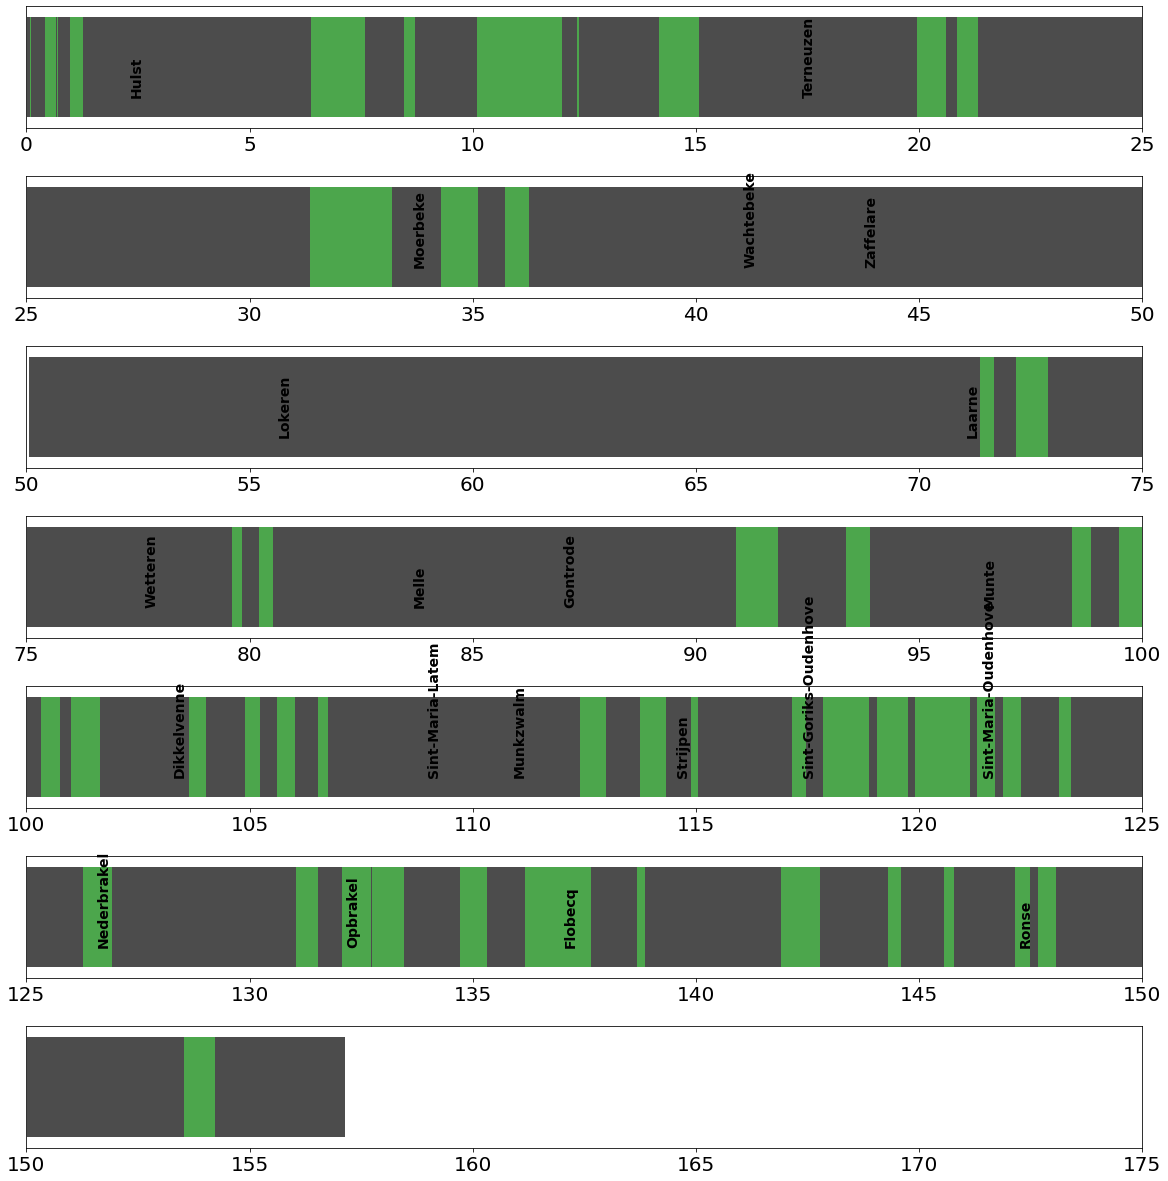

In [223]:
fig, ax = plt.subplots(n_plots,1,figsize=(20,3*n_plots))
plt.rc('font', size=20)
for k in range(n_plots):
    # Indices of this subset
    i0 = data[data['d0'].gt(k*d_per_plot*1000)].index[0]
    i1_temp = data[data['d0'].gt((k+1)*d_per_plot*1000)]
    if i1_temp.shape[0]>0:
        i1 = i1_temp.index[0]
    else:
        i1 = n_points
    # Drawing this subset
    for i in range(i0,i1):
        x = [data.loc[i,'d0']/1000,data.loc[i,'d1']/1000]
        y = [1,1]
        if data.loc[i,'paved']:
            ax[k].plot(x,y,linewidth=100,color='black',solid_capstyle='butt',alpha=0.7)
        else:
            ax[k].plot(x,y,linewidth=100,color='green',solid_capstyle='butt',alpha=0.7)
    ax[k].set_xlim(k*d_per_plot, (k+1)*d_per_plot)
    ax[k].set_ylim(0.99, 1.01)
    ax[k].set_yticks([])
    for j in range(len(final_cities)):
        thisd = final_cities[j][1]
        if thisd>k*d_per_plot and thisd<(k+1)*d_per_plot:
            ax[k].text(final_cities[j][1], 0.995, final_cities[j][0], rotation=90, fontsize=14, color='black', wrap=True, fontweight='bold')
plt.subplots_adjust(hspace=0.4)
plt.show()

In [212]:
k

6

In [197]:
# Figuring out mean index of each cityname
vc = data['city'].value_counts()
nmin = 100
large_vc = vc>nmin
cities = vc[large_vc].index.tolist() # The cities that occur more than nmin times
cities_imed = []
cities_km = []
for city in cities:
    mask_city = data['city']==city
    temp1 = [int(val==True) for val in mask_city.values.tolist()]
    temp2 = mask_city.index.tolist()
    temp3 = [x*y for x,y in zip(temp1,temp2)]
    med = int(sum(temp3)/sum(temp1))
    cities_imed.append(med)
    medrow = data.iloc[med]
    cities_km.append(np.round(medrow['d0'])/1000)
sort_index = np.argsort(cities_km).tolist()
final_cities = []
for i in range(len(cities)):
    k = sort_index[i]
    final_cities.append([cities[k], cities_km[k]])

In [199]:
final_cities

[['Hulst', 2.559],
 ['Terneuzen', 17.609],
 ['Moerbeke', 33.9],
 ['Wachtebeke', 41.311],
 ['Zaffelare', 44.015],
 ['Lokeren', 55.88],
 ['Laarne', 71.297],
 ['Wetteren', 77.906],
 ['Melle', 83.903],
 ['Gontrode', 87.285],
 ['Munte', 96.673],
 ['Dikkelvenne', 103.537],
 ['Sint-Maria-Latem', 109.225],
 ['Munkzwalm', 111.135],
 ['Strijpen', 114.807],
 ['Sint-Goriks-Oudenhove', 117.613],
 ['Sint-Maria-Oudenhove', 121.65],
 ['Nederbrakel', 126.823],
 ['Opbrakel', 132.422],
 ['Flobecq', 137.292],
 ['Ronse', 147.479]]